In [1]:
import numpy as np
import numpy.fft as nf
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as sc
import time as time

sm = qt.sigmam()
sx = qt.sigmax()
sz = qt.sigmaz()
I  = qt.qeye(2)
gnd = qt.basis(2,1)
exc = qt.basis(2,0)

def H_gen(args):
    ''' Qubit + Transversal drive '''
    wq = args['w_qubit']
    H0 = wq*sz/2
    H1 = sx
    return [H0,[H1,H1_coeff]]

def H1_coeff(t, args):
    ''' Transveral drive '''
    e = args['e_drive']
    w = args['w_drive']
    return e*np.cos(w*t)

def D0_coeff(t, args):
    ''' Qubit relaxation '''
    g = args['gamma']
    return np.sqrt(g)

def HRWA_gen(args):
    ''' RWA version of H_gen '''
    e  = args['e_drive']
    wq = args['w_qubit']
    wd = args['w_drive']
    return -(wd - wq)*sz/2 + (e/2)*(sm + sm.dag())

def w_larmor(args):
    ''' Larmor frequency '''
    e  = args['e_drive']
    wq = args['w_qubit']
    wd = args['w_drive']
    return np.sqrt(e**2+(wq-wd)**2)

def p_rabi(args):
    ''' Maximum excited probability for dissipation less system '''
    e  = args['e_drive']
    wq = args['w_qubit']
    wd = args['w_drive']
    return (e/w_larmor(args))**2

def func_cos(x, w, phi, A, C):
    return A*np.cos(w*x+phi)+C

def fit_cos(x, y, printing=False):
    ''' Use Fourier Transform to feed initial values to cosine fit '''
    y_mean = np.mean(y)
    y_fft  = nf.rfft(y-y_mean, norm='ortho')
    freqs  = nf.rfftfreq(len(x), x[1]-x[0])
    i_gues = np.argmax(np.abs(y_fft))
    w_gues = 2*np.pi*freqs[i_gues]
    p_gues = np.pi*(1-np.sign(np.real(y_fft[i_gues])))/2
    A_gues = (np.max(y) - np.min(y))/2
    p0     = [w_gues, p_gues, A_gues, y_mean]
    popt, pcov = sc.curve_fit(func_cos, x, y, p0=p0)
    if printing:
        print('guess: ', np.round(p0,3))
        print('fit:   ', np.round(popt,3))
        print('------------------------')
    return popt, pcov

def func_lor(x, x0, gamma, A):
    return A/(1+((x-x0)*2/gamma)**2)



1 / 11 :  0.8822431564331055
2 / 11 :  1.103985071182251
3 / 11 :  1.114408016204834
4 / 11 :  1.1399340629577637
5 / 11 :  1.6169848442077637
6 / 11 :  1.5213758945465088
7 / 11 :  1.430250883102417
8 / 11 :  1.4534070491790771
9 / 11 :  1.4726219177246094
10 / 11 :  1.497406244277954
11 / 11 :  1.5180931091308594
gamma input  = 100.0
gamma output = 101.11


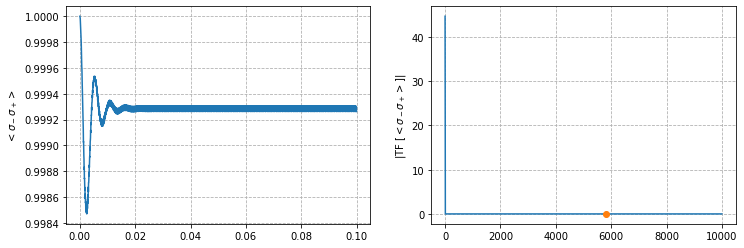

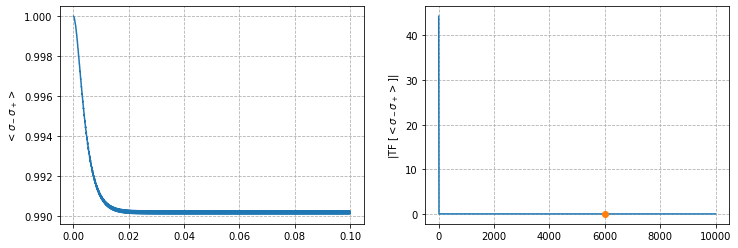

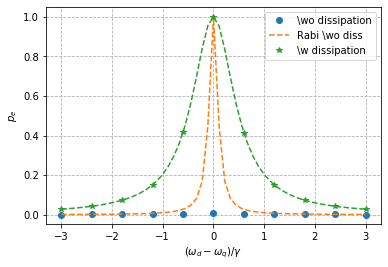

In [28]:
''' Computing the qubit absorption spectrum with dissipation '''
''' The drive amplitude sets the minimum observable linewidth '''

wqbit = 2*np.pi*6000
wdriv = None
edriv = 2*np.pi*1e1
gamma = 2*np.pi*1e2
args  = {'w_qubit':wqbit, 'w_drive':wdriv, 'e_drive':edriv, 'gamma':gamma}

options = qt.Options()
options.nsetps = 10000

H     = H_gen(args)
psi0  = gnd
times = np.linspace(0,0.1,2001)
freqs = nf.rfftfreq(len(times), times[1]-times[0])
D     = [[sm,D0_coeff]]
obs   = [sz, sm*sm.dag()]

N     = 11
span  = 3*gamma
wdriv = np.linspace(wqbit-span, wqbit+span, N)
p_exc = np.zeros(N)
s_abs = np.zeros(N)
for ii, wd in enumerate(wdriv):
    start = time.time()
    args['w_drive'] = wd
    result    = qt.mesolve(H, psi0, times, D, obs, args=args, options=options)  
    p_exc[ii] = (1+np.max(result.expect[0]))/2
#    popt, _   = fit_cos(times, result.expect[1], printing=False)
#    s_abs.append(popt[2])
    smsp_fft  = nf.rfft(result.expect[1], norm='ortho')
    ii_wd     = np.argmin(np.abs(freqs-wd/2/np.pi))
    s_abs[ii] = np.abs(smsp_fft[ii_wd])
    print(ii+1, '/', str(N), ': ', time.time()-start)
    
    if ii in [int(N/4), int(N/2)]:
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        ax[0].plot(times, result.expect[1])
#        ax[0].plot(times, func_cos(times, *popt), '--')
        ax[0].set_ylabel(r'$<\sigma_-\sigma_+>$')
        ax[0].grid(linestyle='--')
        ax[1].plot(freqs[:], np.abs(smsp_fft[:]))
        ax[1].plot(freqs[ii_wd], np.abs(smsp_fft[ii_wd]), 'o')
        ax[1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
        ax[1].grid(linestyle='--')
#        ax[1].set_xlim([-0.5,10])
#        ax[1].set_ylim([0,1])

wdriv_th = np.linspace(wdriv[0], wdriv[-1], 5*N)
p_exc_th = np.zeros(5*N)
for ii, wd in enumerate(wdriv_th):
    args['w_drive'] = wd
    p_exc_th[ii] = p_rabi(args)

s_abs /= np.max(s_abs)
popt, pcov = sc.curve_fit(func_lor, wdriv, s_abs, p0=[wqbit,gamma,1])


fig, ax = plt.subplots()
x_ax    = (wdriv-wqbit)/gamma 
x_ax_th = (wdriv_th-wqbit)/gamma 
ax.plot(x_ax, p_exc, 'o', label='\wo dissipation')
ax.plot(x_ax_th, p_exc_th, '--', label='Rabi \wo diss')
ax.plot(x_ax, s_abs, '*', label='\w dissipation')
ax.plot(x_ax_th, func_lor(wdriv_th, *popt), '--', color='C2', label='Lorentzian fit')
ax.set_ylabel(r'$p_e$')
ax.grid(linestyle='--')
ax.set_xlabel(r'$(\omega_d-\omega_q)/\gamma$')
ax.legend()
print('gamma input  =', np.round(gamma/2/np.pi,2))
print('gamma output =', np.round(popt[1]/2/np.pi,2))

Text(0.5, 0, '$\\varepsilon_{drive}/2/\\pi$')

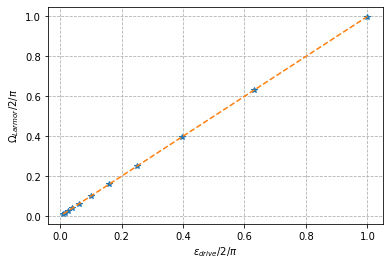

In [38]:
''' Computing the Larmor frequency on resonance '''

wqbit = 2*np.pi*6  
wdriv = 2*np.pi*6
edriv = None
gamma = 2*np.pi*1e-9
args  = {'w_qubit':wqbit, 'w_drive':wdriv, 'e_drive':edriv, 'gamma':gamma}

H     = H_gen(args)
psi0  = gnd
times = np.linspace(0,50,501)
D     = [[sm,D0_coeff]]
obs   = [sz, sm*sm.dag()]

N     = 11
edriv = 2*np.pi*np.logspace(-2, 0, N)
wflop = np.zeros(N)
for ii, ed in enumerate(edriv):
    args['e_drive'] = ed
    result = qt.mesolve(H, psi0, times, D, obs, args=args) 
    popt, pcov = fit_cos(times, result.expect[0])
    wflop[ii] = popt[0]

edriv_th = np.linspace(edriv[0], edriv[-1], 5*N)
wflop_th = np.zeros(5*N)
for ii, ed in enumerate(edriv_th):
    args['e_drive'] = ed
    wflop_th[ii] = w_larmor(args)

fig, ax = plt.subplots()
ax.plot(edriv/2/np.pi, wflop/2/np.pi, '*')
ax.plot(edriv_th/2/np.pi, wflop_th/2/np.pi, '--')
ax.set_ylabel(r'$\Omega_{Larmor}/2\pi$')
ax.grid(linestyle='--')
ax.set_xlabel(r'$\varepsilon_{drive}/2\pi$')



elapsed time =  2.4795989990234375


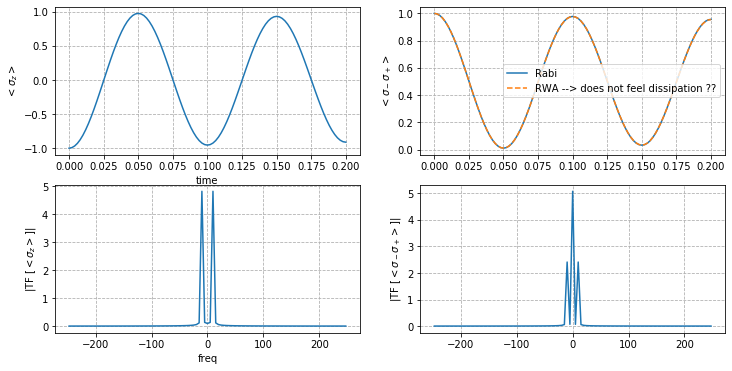

In [19]:
''' Test cell - Time & Frequency visualisation'''

wqbit = 2*np.pi*6000
wdriv = wqbit
edriv = 2*np.pi*1e1
gamma = 2*np.pi*1e-1

options = qt.Options()
options.nsetps = 10000

args  = {'w_qubit':wqbit, 'w_drive':wdriv, 'e_drive':edriv, 'gamma':gamma}
psi0  = gnd
times = np.linspace(0,0.2,101)
D     = [[sm,D0_coeff]]
obs   = [sz, sm*sm.dag()]

start = time.time()
H = H_gen(args)
result = qt.mesolve(H, psi0, times, D, obs, args=args, options=options) 
H_rwa = HRWA_gen(args)
result_rwa = qt.mesolve(H_rwa, psi0, times, D, obs, args=args, options=options) 
print('elapsed time = ', time.time()-start)

sz_fft   = nf.fftshift(nf.fft(result.expect[0], norm='ortho'))
smsp_fft = nf.fftshift(nf.fft(result.expect[1], norm='ortho'))
freqs    = nf.fftshift(nf.fftfreq(len(times), times[1]-times[0]))

fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].plot(times, result.expect[0], '-')
ax[0,0].set_ylabel(r'$<\sigma_z>$')
ax[0,0].grid(linestyle='--')
ax[0,0].set_xlabel('time')
ax[1,0].plot(freqs, np.abs(sz_fft))
ax[1,0].set_ylabel(r'|TF $[<\sigma_z>]$|')
ax[1,0].set_xlabel('freq')
ax[1,0].grid(linestyle='--')
ax[0,1].plot(times, result.expect[1], label='Rabi ')
ax[0,1].plot(times, result_rwa.expect[1], '--', label='RWA --> does not feel dissipation ??')
ax[0,1].legend()
ax[0,1].set_ylabel(r'$<\sigma_-\sigma_+>$')
ax[0,1].grid(linestyle='--')
ax[1,1].plot(freqs[:], np.abs(smsp_fft[:]))
ax[1,1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
ax[1,1].grid(linestyle='--')
#ax[1,1].set_ylim([0,0.2])
